# Entrenamiento del Modelo de Asignación Latente de Dirichlet

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Wikipedia_15_-_Twitter_wordcloud.png" width="500px" height="300px" />

> Ya que comprendimos el modelo de asignación latente de Dirichlet, veamos como entrenarlo.

> **Objetivos:**
> - Usar la inferencia variacional para entrenar el modelo de asignación latente de Dirichlet.
> - Comprender el uso de la asignación latente de Dirichlet mediante un ejemplo.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.

## 1. Preliminares

Tenemos entonces que la función de verosimilitud conjunta es:

$$
p(\Theta, Z, X | \Phi) = \prod_{d=1}^{D} p(\theta_d) \prod_{n=1}^{N_d} p(z_{dn} | \theta_d) p(x_{dn} | z_{dn}),
$$

de donde la log-verosimilitud es:

\begin{align}
\log p(\Theta, Z, X | \Phi) = \sum_{d=1}^{D} \left[\log p(\theta_d) + \sum_{n=1}^{N_d} \left( \log p(z_{dn} | \theta_d) + \log p(x_{dn} | z_{dn}) \right) \right]
\end{align}

Ahora, dado que 

- $p(\theta_d) = \text{Dir}(\theta | \alpha)$
- $p(z_{dn} | \theta_d) = \theta_{d z_{dn}}$
- $p(x_{dn} | z_{dn}) = \phi_{z_{dn} x_{dn}}$

Es posible notar que:

- $\log p(\theta_d) = \sum_{t=1}^{T} (\alpha_t - 1) \log \theta_{dt} + const.$
- $\log p(z_{dn} | \theta_d) = \log \theta_{d z_{dn}}$
- $\log p(x_{dn} | z_{dn}) = \log \phi_{z_{dn} x_{dn}}$

Con lo cual

\begin{align}
\log p(\Theta, Z, X | \Phi) = \sum_{d=1}^{D} \left[\sum_{t=1}^T (\alpha_t-1) \log \theta_{dt} + \sum_{n=1}^{N_d} \sum_{t=1}^T \delta(z_{dn} = t) \left( \log \theta_{dt} + \log \phi_{t x_{dn}} \right) \right] + const.
\end{align}

Para entrenar los parámetros del modelo $\Phi$, podemos maximizar la verosimilitud marginal:

$$
\max_{\Phi} p(X | \Phi),
$$

para lo cual usamos el algoritmo de maximización de la esperanza variancional:

**E-step variacional**

$$
\min_{q(\Theta), q(Z)}\mathcal{KL}(q(\Theta) q(Z) || p(\Theta, Z | X)).
$$

**M-Step**

$$
\max_{\Phi} \mathbb{E}_{q(\Theta)q(Z)}\log p(\Theta, Z, X | \Phi)
$$

## 2. E-step variacional

$$
\min_{q(\Theta), q(Z)}\mathcal{KL}(q(\Theta) q(Z) || p(\Theta, Z | X)).
$$

### Con respecto a $q(\Theta)$

Usando las ecuaciones de campo media:

$$
\begin{align}
\log q(\Theta) & = \mathbb{E}_{q(Z)} \log \underbrace{p(\Theta, Z | X)}_{\frac{p(\Theta, Z, X)}{p(X)}} + const. \\
               & = \mathbb{E}_{q(Z)} \log p(\Theta, Z, X) + const. \\
               & = \mathbb{E}_{q(Z)} \sum_{d=1}^{D} \left[\sum_{t=1}^T (\alpha_t-1) \log \theta_{dt} + \sum_{n=1}^{N_d} \sum_{t=1}^T \delta(z_{dn} = t) \left( \log \theta_{dt} \right) \right] + const. \\
               & = \sum_{d=1}^{D} \left[\sum_{t=1}^T (\alpha_t-1) \log \theta_{dt} + \sum_{n=1}^{N_d} \sum_{t=1}^T \underbrace{\mathbb{E}_{q(Z)}[\delta(z_{dn} = t)]}_{\mathbb{E}_{q(z_{dn})}[\delta(z_{dn} = t)]} \left( \log \theta_{dt} \right) \right] + const. \\
               & = \sum_{d=1}^{D} \left[\sum_{t=1}^T (\alpha_t-1) \log \theta_{dt} + \sum_{n=1}^{N_d} \sum_{t=1}^T q(z_{dn} = t) \left( \log \theta_{dt} \right) \right] + const. \\
               & = \sum_{d=1}^{D} \sum_{t=1}^T \left[ (\alpha_t-1) + \sum_{n=1}^{N_d} q(z_{dn} = t) \right] \log \theta_{dt} + const.
\end{align}
$$

Con lo cual tenemos que:

$$
\begin{align}
q(\Theta) & \propto \prod_{d=1}^{D} \prod_{t=1}^T \theta_{dt}^{\sum_{n=1}^{N_d} q(z_{dn} = t) + \alpha_t - 1} + const. \\
           & = \prod_{d=1}^{D} \text{Dir}\left(\theta_d \left\lvert \begin{array}{c} ... \\ \alpha_t + \sum_{n=1}^{N_d} q(z_{dn} = t) \\ ... \end{array}\right. \right)
\end{align}
$$

De manera que para encontrar $q(\Theta)$, necesitamos calcular $q(z_{dn} = t)$.

### Con respecto a $q(Z)$

Usando las ecuaciones de campo media:

$$
\begin{align}
\log q(Z) & = \mathbb{E}_{q(\Theta)} \log p(\Theta, Z, X) + const. \\
          & = \mathbb{E}_{q(\Theta)} \sum_{d=1}^{D} \sum_{n=1}^{N_d} \sum_{t=1}^T \delta(z_{dn} = t) \left( \log \theta_{dt} + \log \phi_{t x_{dn}} \right) + const. \\
          & = \sum_{d=1}^{D} \sum_{n=1}^{N_d} \sum_{t=1}^T \delta(z_{dn} = t) \left(\mathbb{E}_{q(\Theta)} \log \theta_{dt} + \log \phi_{t x_{dn}} \right) + const.
\end{align}
$$

Por tanto:

$$
\begin{align}
q(Z) & = \prod_{d=1}^{D} \prod_{n=1}^{N_d} q(z_{dn}),
\end{align}
$$

donde

$$
q(z_{dn} = t) = \frac{\phi_{t x_{dn}} \exp\left(\mathbb{E}_{q(\Theta)} \log \theta_{dt}\right)}{\sum_{t=1}^T \phi_{t x_{dn}} \exp\left(\mathbb{E}_{q(\Theta)} \log \theta_{dt}\right)}.
$$

El valor de 

$$
\exp\left(\mathbb{E}_{q(\Theta)} \log \theta_{dt}\right)
$$

se puede encontrar en:

https://en.wikipedia.org/wiki/Dirichlet_distribution

**¿Recuerdan el modelo de Iising?**

Debemos iterar para que estas distribuciones converjan.

## 3. M-step

$$
\max_{\Phi} \mathbb{E}_{q(\Theta)q(Z)}\log p(\Theta, Z, X | \Phi)
$$

Conservamos solo los términos que dependen de $\Phi$:

$$
\begin{align}
\mathbb{E}_{q(\Theta)q(Z)}\log p(\Theta, Z, X | \Phi) & = \mathbb{E}_{q(\Theta)q(Z)}\sum_{d=1}^{D} \sum_{n=1}^{N_d} \sum_{t=1}^T \delta(z_{dn} = t)  \log \phi_{t x_{dn}} + const.
\end{align}
$$

Debemos maximizar esta expresión teniendo en cuenta las restricciones:

- $\phi_{tx} \geq 0, \quad \forall t, x$.
- $\sum_{x} \phi_{tx} = 1, \quad \forall t$

La condición de no negatividad se satisface ya que los términos $\phi$ están dentro del $\log$.

Definimos el lagrangiano:

$$
\begin{align}
L(\Phi, \lambda) & = \mathbb{E}_{q(\Theta)q(Z)}\sum_{d=1}^{D} \sum_{n=1}^{N_d} \sum_{t=1}^T \delta(z_{dn} = t)  \log \phi_{t x_{dn}} + \sum_{t=1}^T \lambda_t \left( \sum_{x} \phi_{tx} - 1 \right) \\
                 & = \sum_{d=1}^{D} \sum_{n=1}^{N_d} \sum_{t=1}^T q(z_{dn} = t)  \log \phi_{t x_{dn}} - \sum_{t=1}^T \lambda_t \left( \sum_{x} \phi_{tx} - 1 \right)
\end{align}
$$

Entonces

$$
\frac{\partial L(\Phi, \lambda)}{\partial \phi_{tx}} = \sum_{d=1}^{D} \sum_{n=1}^{N_d} q(z_{dn} = t) \frac{1}{\phi_{t x_{dn}}} \delta(x_{dn} = x) - \lambda_t = 0
$$

si y solo si:

$$
\phi_{tx} = \frac{\sum_{d=1}^{D} \sum_{n=1}^{N_d} q(z_{dn} = t) \delta(x_{dn} = x)}{\lambda_t}
$$

Ahora, imponiendo la restricción $\sum_{x} \phi_{tx} = 1$, nos damos cuenta que:

$$
\lambda_t = \sum_{x}\sum_{d=1}^{D} \sum_{n=1}^{N_d} q(z_{dn} = t) \delta(x_{dn} = x)
$$

Con lo cual:

$$
\phi_{tx} = \frac{\sum_{d=1}^{D} \sum_{n=1}^{N_d} q(z_{dn} = t) \delta(x_{dn} = x)}{\sum_{x}\sum_{d=1}^{D} \sum_{n=1}^{N_d} q(z_{dn} = t) \delta(x_{dn} = x)}.
$$

## 4. Comentarios

Hemos desarrollado las fórmulas para entrenar nuestro modelo. Recordamos que

1. Hay que iterar varias veces el E-step y el M-step hasta la convergencia de los parámetros en la matriz $\Phi$.
   - La matriz $\Phi$ contiene la distribución tópico-palabras. De acá podemos identificar qué palabras son más importantes para cada tópico y así inferir el tópico.
   
2. Dentro del E-step en sí, hay que iterar hasta la convergencia de las distribuciones $q(\Theta), q(Z)$.

3. Al final, la distribución $q(\Theta)$ modelará las distribuciones de documentos-tópicos. Podremos extraer de los parámetros $\alpha$ la representación de los documentos en los tópicos.

5. Si quisiéramos predecir para un nuevo documento, podemos reutilizar las ecuaciones del E-step.

## 5. Aplicación

Para finalizar todas estas matemáticas, veamos un ejemplo para aterrizar todo lo que hemos visto en este tema.

Para trabajar, utilizaremos [the 20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/)

In [23]:
# Importamos librerías
# Para obtener los datos
from sklearn.datasets import fetch_20newsgroups
# Para procesar el texto
from sklearn.feature_extraction.text import CountVectorizer
# Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation
# Para graficar
from matplotlib import pyplot as plt

In [7]:
# Obtenemos datos
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)

In [9]:
# Visualizamos datos
data[:5]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [10]:
# ¿Cuántos documentos tenemos?
len(data)

11314

In [14]:
# Definamos algunas cosas
# Número de documentos
n_docs = 3000
# Número de tópicos
n_topics = 10
# Número de palabras en el vocabulario
n_words = 1000

In [15]:
# Vectorizamos el texto por medio de cuentas crudas de palabras
vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                             max_features=n_words,
                             stop_words='english')
corpus = vectorizer.fit_transform(data[:n_docs])

In [16]:
# Matriz de documentos vectorizados
corpus

<3000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 77074 stored elements in Compressed Sparse Row format>

In [24]:
def plot_top_words(model, feature_names, n_top_words, title):
    # Malla para graficar 2 filas 5 columnas
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    # model.components_ hace referencia a la matriz phi
    for topic_idx, topic in enumerate(model.components_):
        # La hacemos distribución
        topic /= topic.sum()
        # Seleccionamos los índices más relevantes del tópico
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        # Obtenemos las palabras
        top_features = [feature_names[i] for i in top_features_ind]
        # Obtenemos la ponderación
        weights = topic[top_features_ind]
        
        # Graficamos barras horizontales por tópicos con las palabras más relevantes
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [18]:
lda = LatentDirichletAllocation(n_components=n_topics)

In [19]:
lda.fit(corpus)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

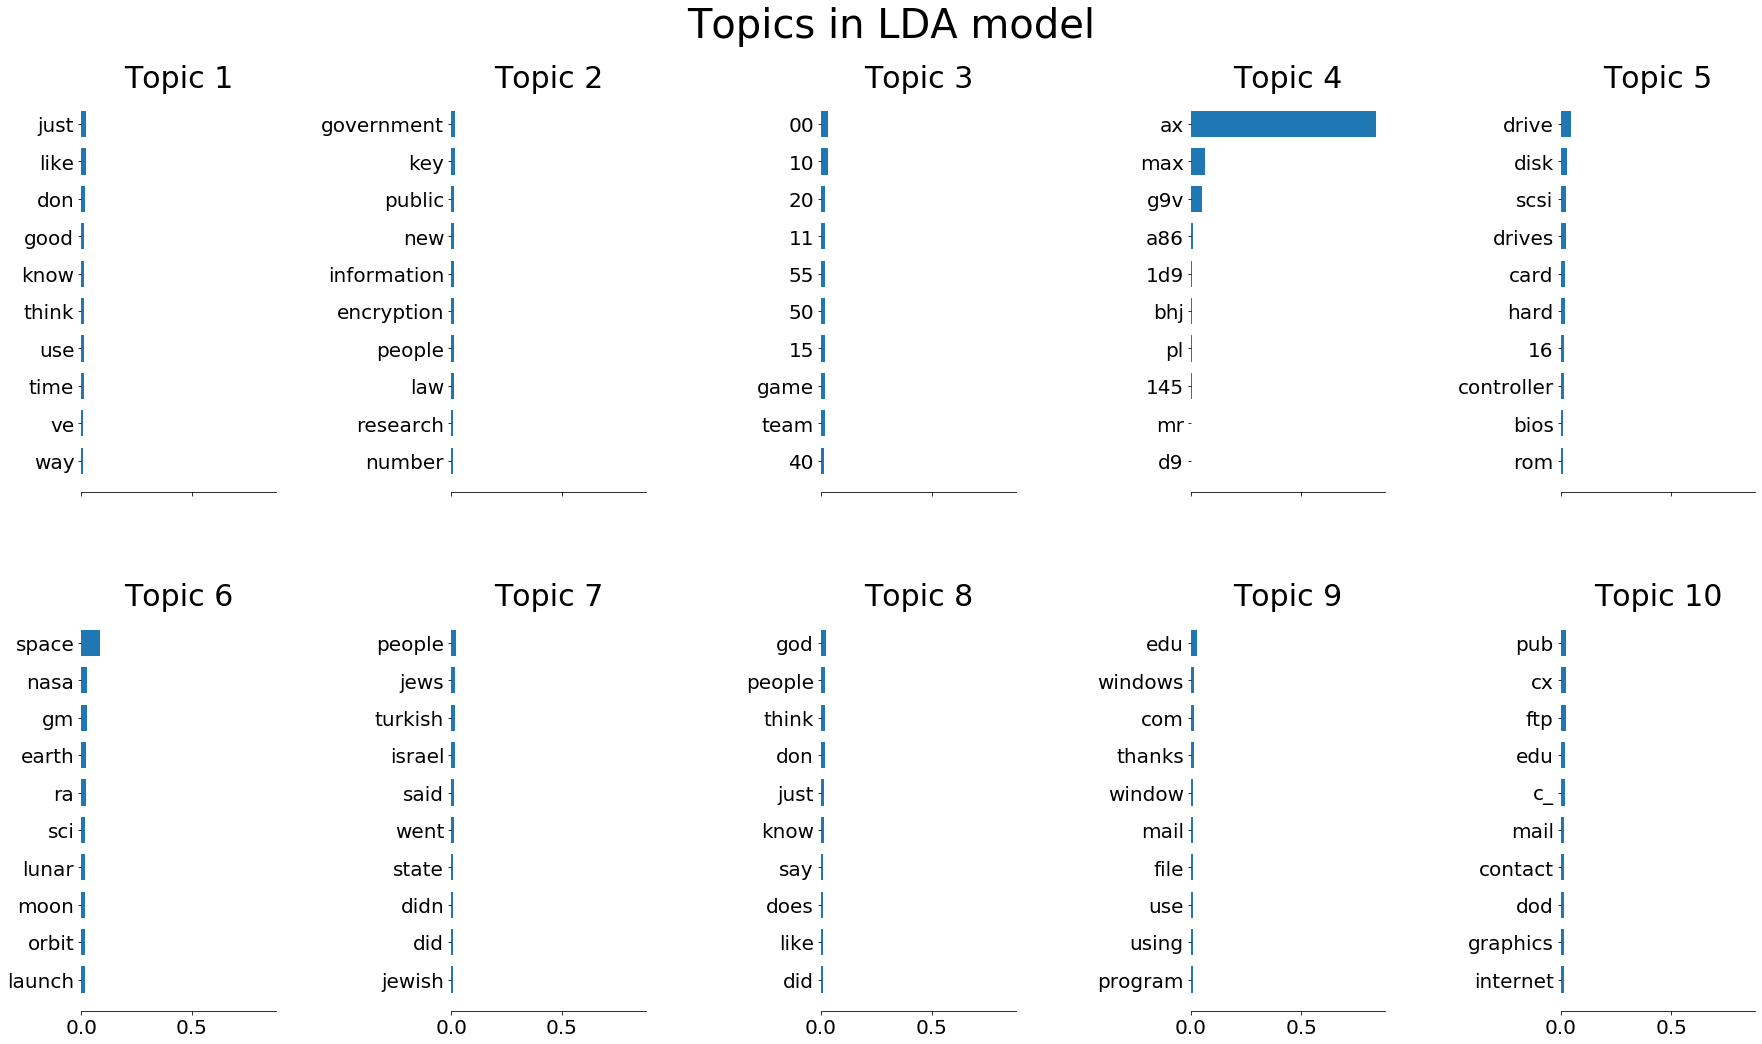

In [25]:
plot_top_words(lda, vectorizer.get_feature_names(), 10, 'Topics in LDA model')

#### Veamos algunos ejemplos de textos y su categorización en tópicos

In [33]:
print(data[0])
lda.transform(corpus[0])

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.



array([[0.00344938, 0.28113703, 0.00344863, 0.00344828, 0.00344897,
        0.003449  , 0.42732285, 0.26739872, 0.00344878, 0.00344836]])

In [35]:
print(data[101])
lda.transform(corpus[101])


The Fluke 87 beeps at you if you try to take it out of a current measuring
range while there is still a lead plugged in to the current sense socket.

... this should solve your problem - unless you are in a noisy environment.

JohnH

----------------------------------------------------------------------------

      |  _  |_   _   |_|  _   _|  _|              Electronics Department
    |_| (_) | | | |  | | (_| (_| (_| \/           School of MPCE
    ---------------------------------/-           Macquarie University
                                                  Sydney, AUSTRALIA 2109

    Email: johnh@mpce.mq.edu.au, Ph: +61 2 805 8959, Fax: +61 2 805 8983



array([[0.40506248, 0.00625273, 0.00625021, 0.00625   , 0.00625148,
        0.00625132, 0.0062527 , 0.00625259, 0.13036411, 0.42081239]])

In [38]:
print(data[251])
lda.transform(corpus[251])

A while back someone had several equations which could be used for changing 3 f
iltered grey scale images into one true color image.  This is possible because
it's the same theory used by most color scanners.  I am not looking for the obv
ious solution which is to buy a color scanner but what I do need is those equat
ions becasue I am starting to write software which will automate the conversion
 process.  I would really appreciate it if someone would repost the 3 equations
/3 unknowns.   Thanks for the help!!!



array([[0.18916581, 0.00500063, 0.00500003, 0.005     , 0.00500067,
        0.00500084, 0.00500044, 0.0050012 , 0.77082958, 0.0050008 ]])

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>